In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import os, sys
%matplotlib inline

os.chdir('..\..\..\..')

from input_configuration import base_year

from IPython.display import display, HTML

if (sys.version_info < (3, 0)):
    HTML('''<script>
    code_show=true; 
    function code_toggle() {
     if (code_show){
     $('div.input').hide();
     } else {
     $('div.input').show();
     }
     code_show = !code_show
    } 
    $( document ).ready(code_toggle);
    </script>
    <form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')


In [2]:
working_dir = r'outputs/agg/dash'
# pd.options.display.float_format = '{:0,.0f}'.format
format_percent = "{:,.2%}".format

In [3]:
def load_data(fname):
    """ open and join model and survey data """

    df_model = pd.read_csv(os.path.join(working_dir,fname+'.csv'))
    df_model['source'] = 'model'
    df_survey = pd.read_csv(os.path.join(working_dir,'survey',fname+'.csv'))
    df_survey['source'] = 'survey'
    df = df_model.append(df_survey)

    return df

In [4]:
parcel_geog = pd.read_sql_table('parcel_'+base_year+'_geography', 'sqlite:///inputs/db/soundcast_inputs.db',
        columns=['CountyName','ParcelID'])

# Usual Work Distance

In [5]:
person = pd.read_csv(r'outputs/daysim/_person.tsv', delim_whitespace=True)
person_survey = pd.read_csv(r'inputs/base_year/survey/_person.tsv', delim_whitespace=True)

person['source'] = 'model'
person_survey['source'] = 'survey'

In [6]:
person = person.append(person_survey)
person = person.merge(parcel_geog, left_on='pwpcl', right_on='ParcelID', how='left')

In [7]:
person['wt_pwautime'] = person['pwautime']*person['psexpfac']
person['wt_pwaudist'] = person['pwaudist']*person['psexpfac']

Average Distance for **All Workers** Not Working at Home (weighted for survey)

In [8]:
df = person[(person['pwtaz'] > 0) & (person['pwaudist'] > 0)]
df.groupby('source').sum()['wt_pwaudist']/df.groupby('source').sum()['psexpfac']

source
model     11.475825
survey    11.728572
dtype: float64

Average Distance by Work County

In [9]:
df1 = df.groupby(['CountyName', 'source']).sum()[['wt_pwaudist']]
df2 = df.groupby(['CountyName', 'source']).sum()[['psexpfac']]
_df = df1.merge(df2, left_index=True, right_index=True)
_df = pd.DataFrame(_df['wt_pwaudist']/_df['psexpfac'])
_df.pivot_table(index='CountyName', columns='source', values=0, aggfunc='sum')

source,model,survey
CountyName,,
King,9.668685,10.138986
Kitsap,12.375732,11.625212
Pierce,12.021253,11.431868
Snohomish,12.329577,13.318881


Average for **Full-Time** Workers only

In [10]:
df = person[(person['pwtaz'] > 0) & (person['pwaudist'] > 0) & (person['pwtyp'] == 1)]
df.groupby('source').sum()['wt_pwaudist']/df.groupby('source').sum()['psexpfac']

source
model     12.239210
survey    12.453758
dtype: float64

In [11]:
df1 = df.groupby(['CountyName', 'source']).sum()[['wt_pwaudist']]
df2 = df.groupby(['CountyName', 'source']).sum()[['psexpfac']]
_df = df1.merge(df2, left_index=True, right_index=True)
_df = pd.DataFrame(_df['wt_pwaudist']/_df['psexpfac'])
_df.pivot_table(index='CountyName', columns='source', values=0, aggfunc='sum')

source,model,survey
CountyName,,
King,10.419254,11.023266
Kitsap,13.203692,12.175897
Pierce,12.842345,11.814593
Snohomish,12.971327,14.009379


Average for **Part-Time** Workers Only

In [12]:
df = person[(person['pwtaz'] > 0) & (person['pwaudist'] > 0) & (person['pwtyp'] == 1)]
df.groupby('source').sum()['wt_pwaudist']/df.groupby('source').sum()['psexpfac']

source
model     12.239210
survey    12.453758
dtype: float64

In [13]:
df1 = df.groupby(['CountyName', 'source']).sum()[['wt_pwaudist']]
df2 = df.groupby(['CountyName', 'source']).sum()[['psexpfac']]
_df = df1.merge(df2, left_index=True, right_index=True)
_df = pd.DataFrame(_df['wt_pwaudist']/_df['psexpfac'])
_df.pivot_table(index='CountyName', columns='source', values=0, aggfunc='sum')

source,model,survey
CountyName,,
King,10.419254,11.023266
Kitsap,13.203692,12.175897
Pierce,12.842345,11.814593
Snohomish,12.971327,14.009379


## Trip Length Distribution (miles)
Percent of Total, bins of 1 mile up to 60 miles

All Workers

<AxesSubplot:xlabel='pwaudist_bin'>

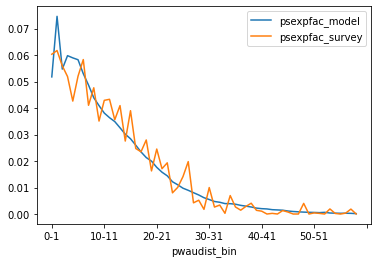

In [13]:
# Create bins
max_bin = 60
person['pwaudist_bin'] = pd.cut(person['pwaudist'], bins=range(0,max_bin), labels=[str(i)+'-'+str(i+1) for i in range(0,max_bin-1)])
df1 = person[(person['source'] == 'model') & (person['pwaudist'] <= max_bin) & (person['pwaudist'] > 0)]
df2 = person[(person['source'] == 'survey') & (person['pwaudist'] <= max_bin) & (person['pwaudist'] > 0)]
df1 = df1.groupby('pwaudist_bin').sum()[['psexpfac']]/df1['psexpfac'].sum()
df2 = df2.groupby('pwaudist_bin').sum()[['psexpfac']]/df2['psexpfac'].sum()
df = df1.merge(df2, left_index=True, right_index=True, suffixes=['_model','_survey'])
df.plot()

Bins of 5 miles, up to 50 miles

<AxesSubplot:xlabel='pwaudist_bin'>

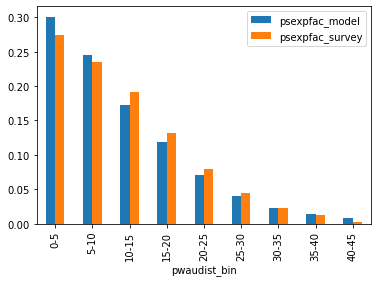

In [14]:
# Create bins
max_bin = 50
person['pwaudist_bin'] = pd.cut(person['pwaudist'], bins=range(0,max_bin,5), labels=[str(i*5)+'-'+str((i+1)*5) for i in range(0,9)])
df1 = person[(person['source'] == 'model') & (person['pwaudist'] <= max_bin) & (person['pwaudist'] > 0)]
df2 = person[(person['source'] == 'survey') & (person['pwaudist'] <= max_bin) & (person['pwaudist'] > 0)]
df1 = df1.groupby('pwaudist_bin').sum()[['psexpfac']]/df1['psexpfac'].sum()
df2 = df2.groupby('pwaudist_bin').sum()[['psexpfac']]/df2['psexpfac'].sum()
df = df1.merge(df2, left_index=True, right_index=True, suffixes=['_model','_survey'])
df.plot(kind='bar')

## County to County Work Flows

All Workers

Model Results

In [43]:
df = load_data(r'work_flows')
pd.options.display.float_format = '{:0,.0f}'.format
df.rename(columns={'person_county': 'Home County', 'person_work_county':'Work County'}, inplace=True)

df_model = pd.pivot_table(df[df['source'] == 'model'], index='Home County', columns='Work County', aggfunc='sum')
df_model['Total'] = df_model.sum(axis=1)
df_model.loc['Total',:] = df_model.sum(axis=0)
df_model

psexpfac                               Total
Work County     King  Kitsap  Pierce Snohomish          
Home County                                             
King         438,444  33,537  94,999   150,603   717,583
Kitsap        13,177  30,281  49,693    91,164   184,315
Pierce        41,663  43,972 160,882   212,159   458,676
Snohomish     31,157  49,993 125,864   266,571   473,585
Total        524,441 157,783 431,438   720,497 1,834,159

Survey Results

In [44]:
df_survey = pd.pivot_table(df[df['source'] == 'survey'], index='Home County', columns='Work County', aggfunc='sum')
df_survey['Total'] = df_survey.sum(axis=1)
df_survey.loc['Total',:] = df_survey.sum(axis=0)
df_survey

psexpfac                               Total
Work County     King  Kitsap  Pierce Snohomish          
Home County                                             
King         406,930  25,365  65,782   126,464   624,541
Kitsap         3,263  45,584  54,811    76,077   179,735
Pierce        40,335  30,436 123,460   156,552   350,783
Snohomish     13,123  29,829 116,267   227,559   386,778
Total        463,651 131,214 360,320   586,652 1,541,837

Total Difference (Model - Survey)

In [45]:
df_model-df_survey

psexpfac                            Total
Work County     King  Kitsap Pierce Snohomish        
Home County                                          
King          31,514   8,172 29,217    24,139  93,042
Kitsap         9,914 -15,303 -5,118    15,087   4,580
Pierce         1,328  13,536 37,422    55,607 107,893
Snohomish     18,034  20,164  9,597    39,012  86,807
Total         60,790  26,569 71,118   133,845 292,322

Percent Difference (Relative to Survey)

In [36]:
((df_model-df_survey)/df_survey).applymap(format_percent)

psexpfac                           
Work County     King   Kitsap  Pierce Snohomish
Home County                                    
King           7.74%   32.22%  44.42%    19.09%
Kitsap       303.88%  -33.57%  -9.34%    19.83%
Pierce         3.29%   44.47%  30.31%    35.52%
Snohomish    137.43%   67.60%   8.25%    17.14%

# Work Tour Distance

### Total

In [183]:
df = load_data('tour_distance')
# Trim any unreasonable survey distances off by taking max distance as max modeled bin value
max_model_dist = df.loc[(df['source']=='model'), 'tautodist_bin'].max()
df = df.loc[df['tautodist_bin'] <= max_model_dist]
df = df[(df['pdpurp'] == 'Work')]
df['wt_autodist'] = (df['tautodist_bin']+0.5)*(df['toexpfac'])
df = df.groupby('source').sum()
pd.DataFrame(df['wt_autodist']/df['toexpfac'], columns=['Work Commute Distance (miles)'])

,Work Commute Distance (miles)
source,
model,11.439409
survey,10.979529


### By Mode

In [203]:
df = load_data('tour_distance')
# Trim any unreasonable survey distances off by taking max distance as max modeled bin value
max_model_dist = df.loc[(df['source']=='model'), 'tautodist_bin'].max()
df = df.loc[df['tautodist_bin'] <= max_model_dist]
df['wt_autodist'] = (df['tautodist_bin']+0.5)*(df['toexpfac'])
df_dist = pd.DataFrame()
for source in ['model','survey']:
    _df = df[(df['source'] == source) & (df['pdpurp'] == 'Work')]
    df1 = _df.groupby('tmodetp').sum()[['wt_autodist']].reset_index()
    df2 = _df.groupby('tmodetp').sum()[['toexpfac']].reset_index ()
    _df = df1.merge(df2, on='tmodetp')
    _df['commute_distance'] = _df['wt_autodist']/_df['toexpfac']
    _df['source'] = source
    df_dist = df_dist.append(_df)
df = df_dist.pivot_table(index='tmodetp', columns='source', aggfunc='first', values='commute_distance')
df.rename(columns={'temodetp': 'Tour Mode'}, inplace=True)
df.drop(['School Bus', 'Park'], axis=0, inplace=True)
df

source,model,survey
tmodetp,,
Bike,5.565858,4.588920
HOV2,11.469063,10.330636
HOV3+,11.841534,14.394094
SOV,12.022697,11.008877
TNC,6.006925,4.475837
Transit,12.911899,11.022154
Walk,0.762817,1.693188


### By Worker Type

In [205]:
df = load_data('tour_distance')
# Trim any unreasonable survey distances off by taking max distance as max modeled bin value
max_model_dist = df.loc[(df['source']=='model'), 'tautodist_bin'].max()
df = df.loc[df['tautodist_bin'] <= max_model_dist]
df['wt_autodist'] = (df['tautodist_bin']+0.5)*(df['toexpfac'])
df_dist = pd.DataFrame()
for source in ['model','survey']:
    _df = df[(df['source'] == source) & 
             (df['pdpurp'] == 'Work') & 
             (df['pptyp'].isin(['Full-Time Worker','Part-Time Worker','University Student']))]
    df1 = _df.groupby('pptyp').sum()[['wt_autodist']].reset_index()
    df2 = _df.groupby('pptyp').sum()[['toexpfac']].reset_index()
    _df = df1.merge(df2, on='pptyp')
    _df['commute_distance'] = _df['wt_autodist']/_df['toexpfac']
    _df['source'] = source
    df_dist = df_dist.append(_df)
df = df_dist.pivot_table(index='pptyp', columns='source', aggfunc='first', values='commute_distance').reset_index()
df.rename(columns={'pptyp': 'Person Type'}, inplace=True)
df

source,Person Type,model,survey
0,Full-Time Worker,11.974886,11.752860
1,Part-Time Worker,8.664870,6.824597
2,University Student,7.387945,7.325001


# Work Tour Time
### By Mode

In [209]:
df = load_data('tour_time')
# The survey includes some extremely long commute times (655 minutes or 10 hours)
# Take the max from the survey to be no higher than max value from the model 199 minutes or 3.3 hours
max_model_time = df.loc[(df['source']=='model'), 'tautotime_bin'].max()
df = df.loc[df['tautotime_bin'] <= max_model_time]
df['wt_autotime'] = (df['tautotime_bin']+0.5)*(df['toexpfac'])
df_dist = pd.DataFrame()
for source in ['model','survey']:
    _df = df[(df['source'] == source) & (df['pdpurp'] == 'Work')]
    df1 = _df.groupby('tmodetp').sum()[['wt_autotime']].reset_index()
    df2 = _df.groupby('tmodetp').sum()[['toexpfac']].reset_index()
    _df = df1.merge(df2, on='tmodetp')
    _df['commute_time'] = _df['wt_autotime']/_df['toexpfac']
    _df['source'] = source
    df_dist = df_dist.append(_df)
df = df_dist.pivot_table(index='tmodetp', columns='source', aggfunc='first', values='commute_time')
df.rename(columns={'temodetp': 'Tour Mode'}, inplace=True)
df.drop(['School Bus', 'Park'], axis=0, inplace=True)
df

source,model,survey
tmodetp,,
Bike,16.615092,26.051694
HOV2,25.933701,23.222910
HOV3+,26.497345,27.681946
SOV,26.757210,23.759949
TNC,17.354887,18.579072
Transit,32.197488,25.826810
Walk,7.703596,19.013965


### Worker Type

In [210]:
df = load_data('tour_time')
# The survey includes some extremely long commute times (655 minutes or 10 hours)
# Take the max from the survey to be no higher than max value from the model 199 minutes or 3.3 hours
max_model_time = df.loc[(df['source']=='model'), 'tautotime_bin'].max()
df = df.loc[df['tautotime_bin'] <= max_model_time]
df['wt_autotime'] = (df['tautotime_bin']+0.5)*(df['toexpfac'])
df_dist = pd.DataFrame()
for source in ['model','survey']:
    _df = df[(df['source'] == source) & 
             (df['pdpurp'] == 'Work') & 
             (df['pptyp'].isin(['Full-Time Worker','Part-Time Worker','University Student']))]
    df1 = _df.groupby('pptyp').sum()[['wt_autotime']].reset_index()
    df2 = _df.groupby('pptyp').sum()[['toexpfac']].reset_index()
    _df = df1.merge(df2, on='pptyp')
    _df['commute_time'] = _df['wt_autotime']/_df['toexpfac']
    _df['source'] = source
    df_dist = df_dist.append(_df)
df = df_dist.pivot_table(index='pptyp', columns='source', aggfunc='first', values='commute_time').reset_index()
df.rename(columns={'pptyp': 'Person Type'}, inplace=True)
df

source,Person Type,model,survey
0,Full-Time Worker,27.199550,26.023712
1,Part-Time Worker,20.419943,17.730876
2,University Student,18.499014,19.900163
